# Preprocess Nodule Images

Preprocess the extracted nodule images using various methods to make them apt for modeling with a Convolutional Neural Network (CNN) for lung cancer detection

In [15]:
import os

# Define the paths to the subfolders
output_folder = './output'
benign_folder = os.path.join(output_folder, 'benign')
malignant_folder = os.path.join(output_folder, 'malignant')

# Initialize lists to store image file paths
benign_images = []
malignant_images = []

# Collect benign images
if os.path.exists(benign_folder):
    benign_images = [os.path.join(benign_folder, f) for f in os.listdir(benign_folder) if os.path.isfile(os.path.join(benign_folder, f))]

# Collect malignant images
if os.path.exists(malignant_folder):
    malignant_images = [os.path.join(malignant_folder, f) for f in os.listdir(malignant_folder) if os.path.isfile(os.path.join(malignant_folder, f))]

# Print the counts for verification
print(f"Found {len(benign_images)} benign images.")
print(f"Found {len(malignant_images)} malignant images.")

Found 315 benign images.
Found 873 malignant images.


Displaying first 5 benign images:


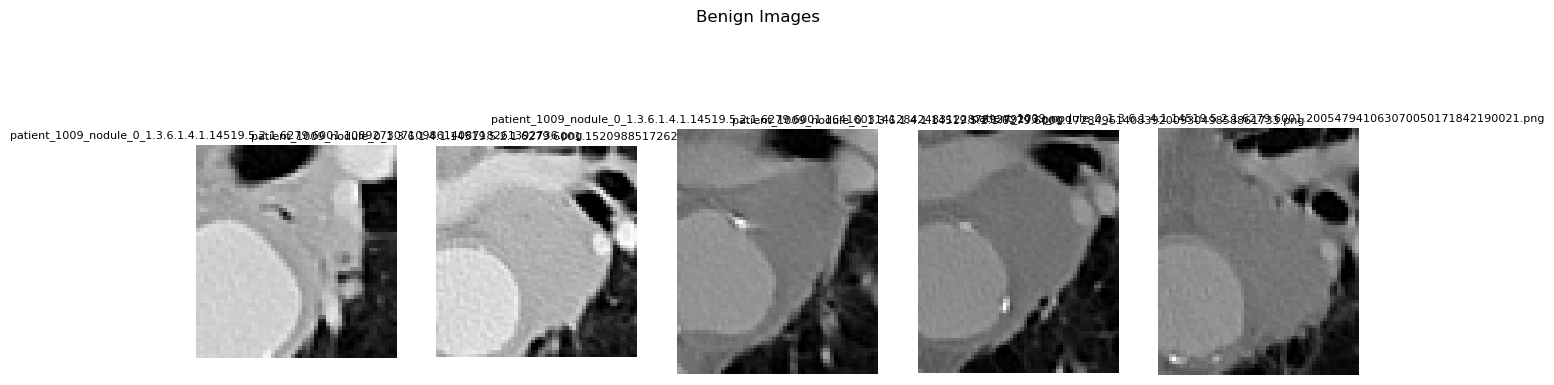

Displaying first 5 malignant images:


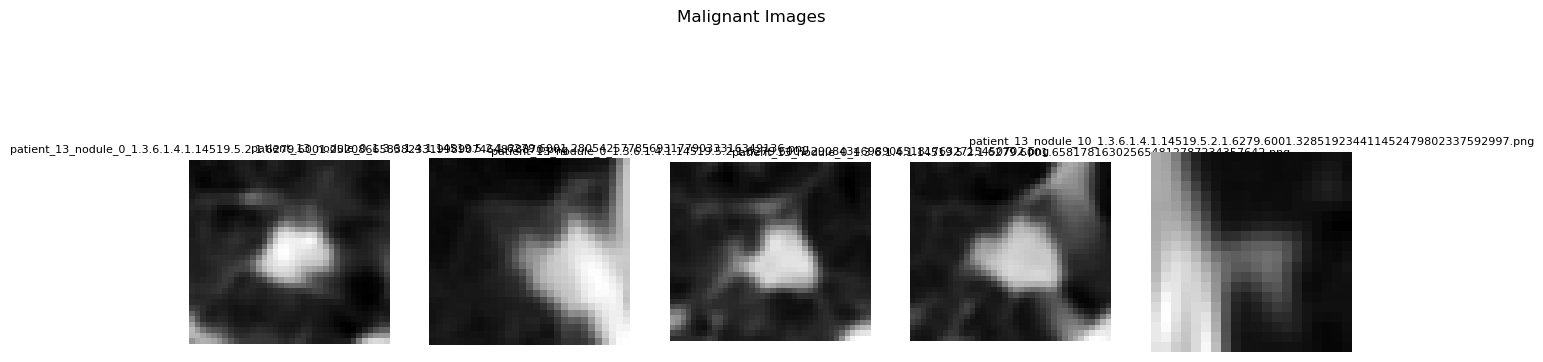

In [16]:
# View first images of each list
import matplotlib.pyplot as plt
from PIL import Image

# Function to display images
def display_images(image_paths, title):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_paths[:5]):  # Display up to 5 images
        try:
            img = Image.open(img_path).convert('L') 
            plt.subplot(1, 5, i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.title(f"{os.path.basename(img_path)}", fontsize=8)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    plt.suptitle(title)
    plt.show()

# Display the first 5 benign images
print("Displaying first 5 benign images:")
display_images(benign_images, "Benign Images")

# Display the first 5 malignant images
print("Displaying first 5 malignant images:")
display_images(malignant_images, "Malignant Images")

## Resize Images

Resize all images to a consistent dimension, necessary for CNNs

In [17]:
from PIL import Image

def resize_images(image_paths, target_size=(128, 128)):
    resized_images = []
    for img_path in image_paths:
        try:
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to target size
            resized_images.append(img)
        except Exception as e:
            print(f"Error resizing image {img_path}: {e}")
    return resized_images

# Resize benign and malignant images
resized_benign = resize_images(benign_images)
resized_malignant = resize_images(malignant_images)

## Normalize Image Pixel Values

Normalize pixel values to range of [0, 1], helps with faster convergence

In [18]:
import numpy as np

def normalize_images(images):
    return [np.array(img) / 255.0 for img in images]

# Normalize resized images
normalized_benign = normalize_images(resized_benign)
normalized_malignant = normalize_images(resized_malignant)

## Augment the Dataset

Use data augmentation techniques using *ImageDataGenerator* to increase the diversity of the dataset and reduce overfitting of the model

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Ensure images have a channel dimension (e.g., (128, 128, 1))
normalized_benign = np.expand_dims(normalized_benign, axis=-1)  # Add channel dimension
normalized_malignant = np.expand_dims(normalized_malignant, axis=-1)  # Add channel dimension

# Convert lists to numpy arrays for compatibility with ImageDataGenerator
normalized_benign = np.array(normalized_benign)
normalized_malignant = np.array(normalized_malignant)

# Initialize the ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Augment benign images to balance the dataset
augmented_benign = []
target_count = len(normalized_malignant)  # Match the number of malignant samples
while len(augmented_benign) + len(normalized_benign) < target_count:
    for img in normalized_benign:
        img = np.expand_dims(img, axis=0)  # Add batch dimension (shape becomes (1, 128, 128, 1))
        for augmented_img in datagen.flow(img, batch_size=1):
            augmented_benign.append(augmented_img[0])  # Remove batch dimension (shape becomes (128, 128, 1))
            if len(augmented_benign) + len(normalized_benign) >= target_count:
                break

# Combine original and augmented benign images
balanced_benign = np.concatenate((normalized_benign, np.array(augmented_benign)))

# Verify the new counts
print(f"Balanced benign samples: {len(balanced_benign)}")
print(f"Malignant samples: {len(normalized_malignant)}")

Balanced benign samples: 1187
Malignant samples: 873


Downsample benign samples to match number of malignant samples

In [20]:
import numpy as np

# Downsample benign samples to match malignant samples
balanced_benign = balanced_benign[:len(normalized_malignant)]  # Keep only the first 873 benign samples

# Combine benign and malignant samples
all_images = np.concatenate((balanced_benign, normalized_malignant))
labels = [0] * len(balanced_benign) + [1] * len(normalized_malignant)  # 0 for benign, 1 for malignant

# Verify the new counts
print(f"Final benign samples: {len(balanced_benign)}")
print(f"Final malignant samples: {len(normalized_malignant)}")

Final benign samples: 873
Final malignant samples: 873


## Split the Dataset
Split dataset into training, validaton, and testing sets using *train_test_split*

In [21]:
from sklearn.model_selection import train_test_split

# Combine benign and malignant images with labels (ensure balanced data is used)
all_images = np.concatenate((balanced_benign, normalized_malignant))  # Use balanced_benign
labels = [0] * len(balanced_benign) + [1] * len(normalized_malignant)  # 0 for benign, 1 for malignant

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(all_images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify the splits
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 1222 samples
Validation set: 262 samples
Test set: 262 samples


## Save Final Preprocessed Data
Save the new preprocessed image datasets for faster loading during model training

In [22]:
import os
import numpy as np

# Create a new folder for preprocessed data
preprocessed_folder = './preprocessed'
os.makedirs(preprocessed_folder, exist_ok=True)

# Save the preprocessed datasets
np.save(os.path.join(preprocessed_folder, 'X_train.npy'), X_train)
np.save(os.path.join(preprocessed_folder, 'y_train.npy'), y_train)
np.save(os.path.join(preprocessed_folder, 'X_val.npy'), X_val)
np.save(os.path.join(preprocessed_folder, 'y_val.npy'), y_val)
np.save(os.path.join(preprocessed_folder, 'X_test.npy'), X_test)
np.save(os.path.join(preprocessed_folder, 'y_test.npy'), y_test)

print(f"Preprocessed data saved to {preprocessed_folder}")

Preprocessed data saved to ./preprocessed
